## Importing libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import f1_score


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
path = '/content/drive/My Drive/Data files for Colab/train.csv'
train = pd.read_csv(path)
train.drop('ID',inplace=True,axis=1)

In [5]:
train.head(2)

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,Reconstructing Subject-Specific Effect Maps,"Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrapper-type\nalgorithm that can be used with different binary classifiers in a diagnostic\nmanner, i.e. without information on condition presence. Reconstruction is posed\nas a Maximum-A-Posteriori problem with a prior model whose parameters are\nestimated from training data in a classifier-specific fashion. Experimental\nevaluation is performed on synthetically generated data and data from the\nAlzheimer's Disease Neuroimaging Initiative (ADNI) database. Results on\nsynthetic data demonstrate that using RSM yields higher detection accuracy\ncompared to using models directly or with bootstrap averaging. Analyses on the\nADNI dataset show that RSM can also improve correlation between\nsubject-specific detections in cortical thickness data and non-imaging markers\nof Alzheimer's Disease (AD), such as the Mini Mental State Examination Score\nand Cerebrospinal Fluid amyloid-$\beta$ levels. Further reliability studies on\nthe longitudinal ADNI dataset show improvement on detection reliability when\nRSM is used.\n",1,0,0,0,0,0
1,Rotation Invariance Neural Network,"Rotation invariance and translation invariance have great values in image\nrecognition tasks. In this paper, we bring a new architecture in convolutional\nneural network (CNN) named cyclic convolutional layer to achieve rotation\ninvariance in 2-D symbol recognition. We can also get the position and\norientation of the 2-D symbol by the network to achieve detection purpose for\nmultiple non-overlap target. Last but not least, this architecture can achieve\none-shot learning in some cases using those invariance.\n",1,0,0,0,0,0


Let us separate the feature and target matrix first. For features, we will only use the abstract based on the assumption that the title's words are largely paraphrased again in the abstract

In [91]:
labels = ['Computer Science', 'Physics', 'Mathematics','Statistics', 'Quantitative Biology', 'Quantitative Finance']

In [6]:
train['length'] = train['ABSTRACT'].apply(len)
train['total'] = train[labels].sum(axis=1)

In [7]:
X = train[['ABSTRACT','length']]
y = train [['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']]

## EDA

Majority of articles i.e. 40% belong to computer science followed by physics, mathematics and statistics between 20 to 30% of articles. Quantitative Biology and Quantiative Finance have fewer articles considering it is a niche field of study   

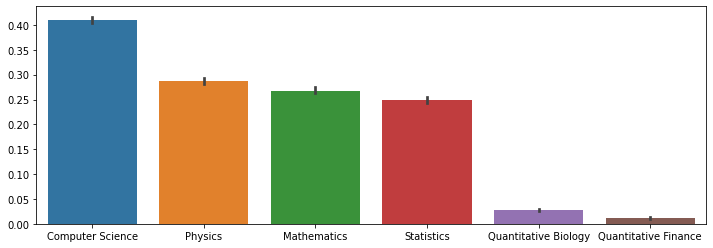

In [8]:
plt.figure(figsize=(12,4))
sns.barplot(data=y);

Majority of the articles i.e. 16k out of 20k entries belong to only one category whereas fewer have 2 and 3 categories attributed to it

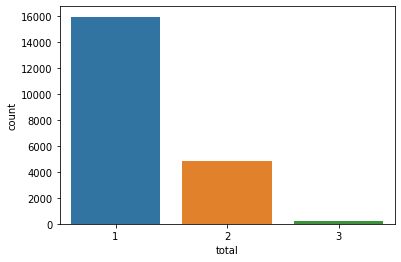

In [9]:
sns.countplot(train['total']);

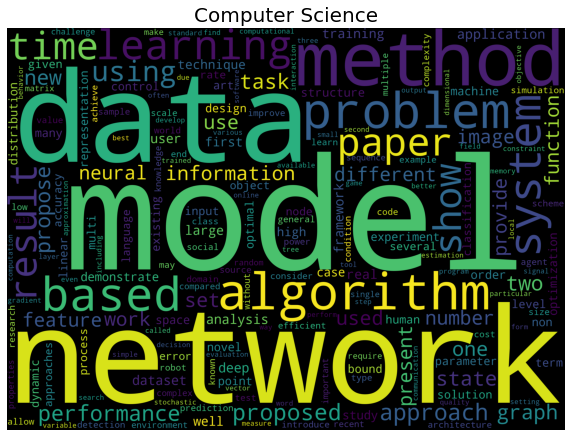

In [10]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(10,10))
subset = train[train['Computer Science']==True]
text = subset['ABSTRACT'].values
cloud_cs = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Computer Science",fontsize=20)
plt.imshow(cloud_cs);

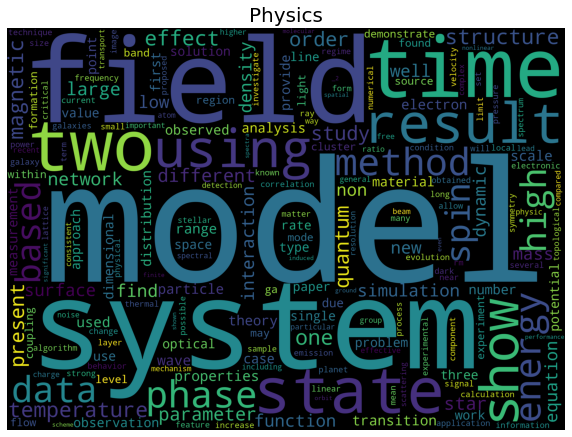

In [11]:
plt.figure(figsize=(10,10))
subset = train[train['Physics']==True]
text = subset['ABSTRACT'].values
cloud_phy = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Physics",fontsize=20)
plt.imshow(cloud_phy);

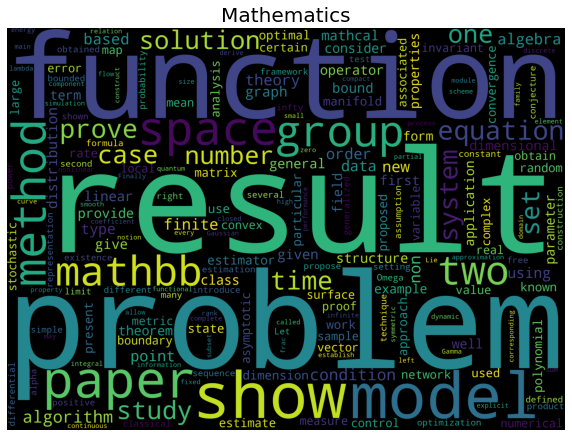

In [12]:
plt.figure(figsize=(10,10))
subset = train[train['Mathematics']==True]
text = subset['ABSTRACT'].values
cloud_math = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Mathematics",fontsize=20)
plt.imshow(cloud_math);

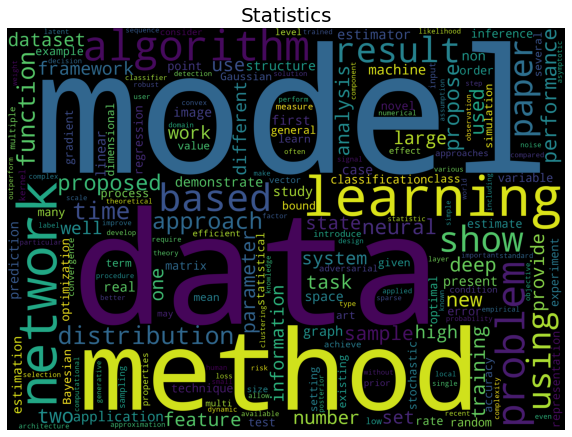

In [13]:
plt.figure(figsize=(10,10))
subset = train[train['Statistics']==True]
text = subset['ABSTRACT'].values
cloud_stat = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Statistics",fontsize=20)
plt.imshow(cloud_stat);

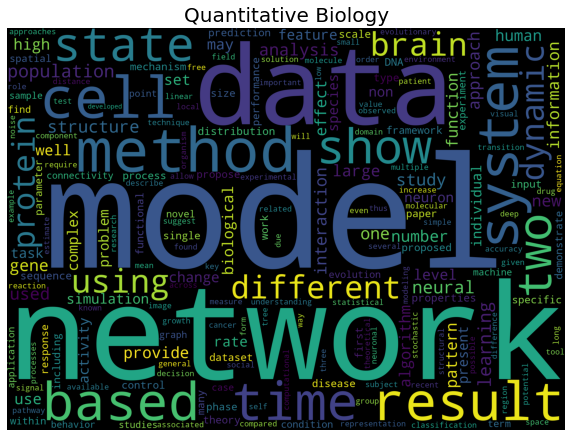

In [14]:
plt.figure(figsize=(10,10))
subset = train[train['Quantitative Biology']==True]
text = subset['ABSTRACT'].values
cloud_qtbio = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Quantitative Biology",fontsize=20)
plt.imshow(cloud_qtbio);

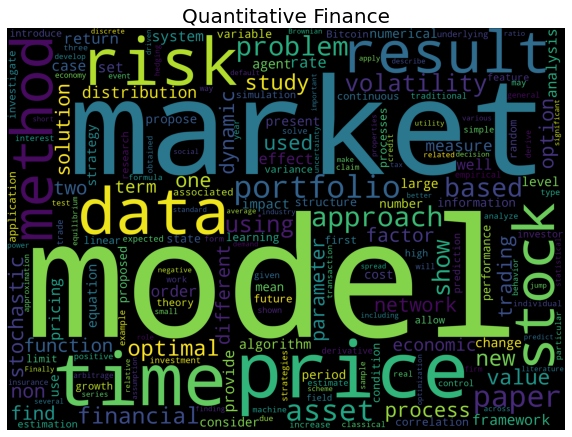

In [15]:
plt.figure(figsize=(10,10))
subset = train[train['Quantitative Finance']==True]
text = subset['ABSTRACT'].values
cloud_qtfin = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Quantitative Finance",fontsize=20)
plt.imshow(cloud_qtfin);

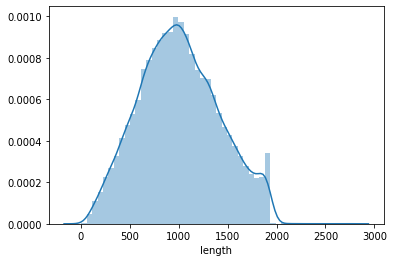

In [16]:
sns.distplot(train['length']);

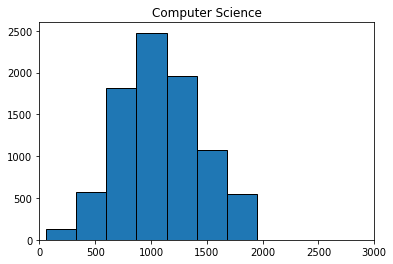

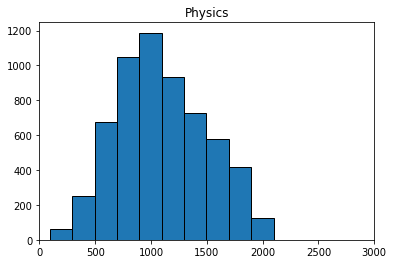

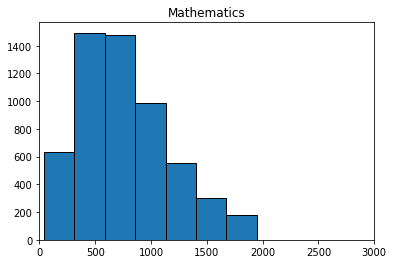

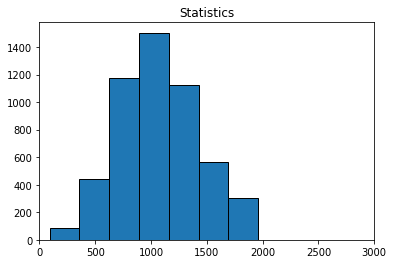

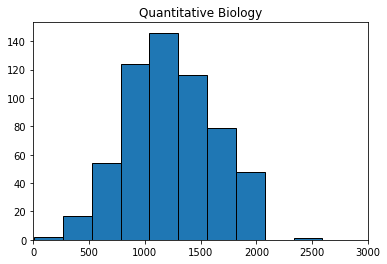

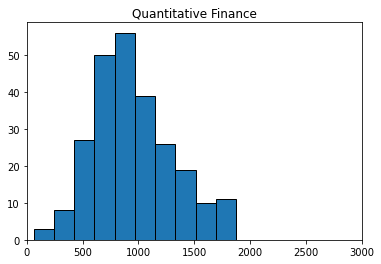

In [17]:
for i in y.columns.to_list():
    plt.hist(train[train[i]==1]['length'],label=i,edgecolor='black')
    plt.xlim(0,3000)
    plt.title(i)
    plt.show()

## Pre-processing the text data

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
corpus = []
for i in range(0, len(X)):
    abstract = re.sub('[^a-zA-Z]', ' ', X['ABSTRACT'][i]) #replacing punctuations with blank space
    abstract = abstract.lower() #converting all words to lower case
    abstract = abstract.split()
    ps = PorterStemmer()
    abstract = [ps.stem(word) for word in abstract if not word in set(stopwords.words('english'))] #stemming words
    abstract = ' '.join(abstract)
    corpus.append(abstract)

In [27]:
corpus[0]

'predict model allow subject specif infer analyz diseas relat alter neuroimag data given subject data infer made two level global e identifiy condit presenc subject local e detect condit effect individu measur extract subject data global infer wide use local infer use form subject specif effect map rare use exist model often yield noisi detect compos dispers isol island articl propos reconstruct method name rsm improv subject specif detect predict model approach particular binari classifi rsm specif aim reduc nois due sampl error associ use finit sampl exampl train classifi propos method wrapper type algorithm use differ binari classifi diagnost manner e without inform condit presenc reconstruct pose maximum posteriori problem prior model whose paramet estim train data classifi specif fashion experiment evalu perform synthet gener data data alzheim diseas neuroimag initi adni databas result synthet data demonstr use rsm yield higher detect accuraci compar use model directli bootstrap a

## Vectorization - Creating bag of words model

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()

In [30]:
X.shape

(20972, 5000)

In [34]:
y.shape

(20972, 6)

In [39]:
# from scipy.sparse import csr_matrix
# y_sparse = csr_matrix(y)

## Splitting the data 

In [52]:
y = train[labels].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [43]:
count_df = pd.DataFrame(X_train, columns=cv.get_feature_names())

## Building the model

In [53]:
print(X_train.shape)
print(y_train.shape)
print(type(y_train))

(14051, 5000)
(14051, 6)
<class 'numpy.ndarray'>


In [58]:
from sklearn.metrics import f1_score, accuracy_score
# using classifier chains
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
classifier = MultiOutputClassifier(RandomForestClassifier())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

print(f1_score(y_test,predictions,average='micro'))

0.7791982127342683


## Predicting test results

In [59]:
test = pd.read_csv('/content/drive/My Drive/Data files for Colab/test.csv')

In [62]:
test.drop(['ID','TITLE'],inplace=True,axis=1)

In [64]:
test.shape

(8989, 1)

In [66]:
test_corpus = []
for i in range(0, len(test)):
    abstract = re.sub('[^a-zA-Z]', ' ', test['ABSTRACT'][i]) #replacing punctuations with blank space
    abstract = abstract.lower() #converting all words to lower case
    abstract = abstract.split()
    ps = PorterStemmer()
    abstract = [ps.stem(word) for word in abstract if not word in set(stopwords.words('english'))] #stemming words
    abstract = ' '.join(abstract)
    test_corpus.append(abstract)

In [67]:
test = cv.transform(test_corpus).toarray()
submission = classifier.predict(test)

In [68]:
submission

array([[0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0]])

In [95]:
labels = ['Computer Science', 'Physics', 'Mathematics','Statistics', 'Quantitative Biology', 'Quantitative Finance']

In [101]:
sub = pd.DataFrame(data=submission,columns=labels)

In [102]:
test_ids = np.arange(20973,29962)
sub['ID'] = test_ids

In [103]:
sub.shape

(8989, 7)

In [106]:
sub = sub[['ID','Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance']]

In [107]:
sub.tail()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
8984,29957,1,0,0,0,0,0
8985,29958,0,0,1,0,0,0
8986,29959,1,0,0,0,0,0
8987,29960,1,0,0,1,0,0
8988,29961,0,0,1,0,0,0


In [108]:
sub.to_csv('submission_v1.csv',index=False)